**Batch Normalization Forward**

In [ ]:
import torch
# Смысл в нормализации актитивации внутри батча
class MyBatchNorm:
    def __init__(self, num_features, eps=1e-5):
        # Параметры
        self.gamma = torch.ones(num_features, requires_grad=True)
        self.beta = torch.zeros(num_features, requires_grad=True)
        self.eps = eps
        # Среднее и дисперсия
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def __call__(self, x):
        if x.dim() == 2:
            # Если размерность 2
            batch_mean = x.mean(dim=0)
            batch_var = x.var(dim=0, unbiased=False)
        else:
            N, C, H, W = x.shape
            batch_mean = x.mean(dim=(0, 2, 3))
            batch_var = x.var(dim=(0, 2, 3), unbiased=False)
            batch_mean = batch_mean.view(1, C, 1, 1)
            batch_var = batch_var.view(1, C, 1, 1)

        # Нормализуем (x - mean) / sqrt(var + eps)
        x_hat = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
        if x.dim() == 2:
            out = self.gamma * x_hat + self.beta
        else:
            out = self.gamma.view(1, -1, 1, 1) * x_hat + self.beta.view(1, -1, 1, 1)
        return out

In [ ]:
x = torch.tensor([[-1.0,  2.0, 3.0], [ 4.0, -5.0, 6.0]])  # 2 s, 3 f
bn = MyBatchNorm(num_features=3)
y = bn(x)
print("BatchNorm", y)


BatchNorm tensor([[-1.0000,  1.0000, -1.0000],
        [ 1.0000, -1.0000,  1.0000]], grad_fn=<AddBackward0>)


**Linear Layer Forward**

In [ ]:
class MyLinear:
    def __init__(self, in_features, out_features):
        self.W = torch.randn(in_features, out_features) * 0.01 # матрица + рандом
        self.b = torch.zeros(out_features) # вектор смещения
        self.W.requires_grad = True
        self.b.requires_grad = True

    def __call__(self, x):
        # умножаем входа и веса
        return x.matmul(self.W) + self.b


In [ ]:
x = torch.tensor([[1.0, 2.0, 3.0]])  # 1 s, 3 f
lin = MyLinear(in_features=3, out_features=2)
y = lin(x)
print("Linear layer output:", y)
print("Output shape:", y.shape)

Linear layer output: tensor([[-0.0249,  0.0752]], grad_fn=<AddBackward0>)
Output shape: torch.Size([1, 2])


**Dropout Forward**

In [ ]:
# Смысл уменьшние переобучения, часть нейронов обнуляется с верояьностью p
class MyDropout:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x):
        if not torch.is_grad_enabled():
            #  Если не трейн, то пропускаем
            return x
        # Маска размером как x с рандромными числами от 0 до 1, если значение > p, оставляем, иначе зануляем.
        mask = (torch.rand_like(x) > self.p).float()
        #
        out = mask * x / (1 - self.p)
        return out

In [ ]:
x = torch.ones((4, 4))
drop = MyDropout(p=0.5)
y = drop(x)
print("Input tensor", x)
print("After Dropout (p=0.5)", y)
print("Fraction of zeros in output", (y == 0).float().mean().item())

Input tensor:
 tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
After Dropout (p=0.5):
 tensor([[2., 2., 0., 0.],
        [0., 0., 0., 2.],
        [2., 2., 2., 2.],
        [2., 0., 2., 2.]])
Fraction of zeros in output ~ 0.375


**Median Filter**   
C, H, W - число каналов (1 - grey, 3 - rgb), H - ширина, W - высота   
Реализуйте медианный фильтр. Для текущего пикселя, пиксели, которые «попадают» в матрицу, сортируются, и выбирается медианное значение из отсортированного массива. Это значение и является выходным для текущего пикселя. Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10

In [ ]:
def median_filter(image_tensor, kernel_size):
    # Если двумерный, то добавим C = 1
    if image_tensor.dim() == 2:
        image = image_tensor.unsqueeze(0)
    else:
        image = image_tensor

    C, H, W = image.shape
    k = kernel_size
    if H < k or W < k:
        # Проверяем размер изображения, должен быть больше размера окна
        return image_tensor
    # ИСпользуем unfold чтобы получить патчи к на к, сначала генерируем все возможные по высоте (k на W), потом по ширине для каждого по высоте
    patches = image.unfold(1, k, 1).unfold(2, k, 1)
    out_H = patches.shape[1] # out_H = H - k + 1
    out_W = patches.shape[2]
    # После двух анфолдов для каждого пикселя, куда можно поставить центр окна k×k, есть свой патч
    patches = patches.contiguous().view(C, out_H, out_W, k*k)
    medians, _ = torch.median(patches, dim=3)
    # переводим в векторы, считаем медиану
    output = image.clone()
    offset = k // 2
    # оставлеяем границу исходной
    output[:, offset:offset+out_H, offset:offset+out_W] = medians
    if image_tensor.dim() == 2:
        return output[0]
    else:
        return output




In [ ]:
import torch
img = torch.tensor([[1, 1, 1, 1, 1],
                    [1, 9, 1, 9, 1],
                    [1, 1, 1, 1, 1],
                    [1, 9, 1, 9, 1],
                    [1, 1, 1, 1, 1]], dtype=torch.float32)
print(img)
filtered = median_filter(img, kernel_size=1)
print(filtered)

tensor([[1., 1., 1., 1., 1.],
        [1., 9., 1., 9., 1.],
        [1., 1., 1., 1., 1.],
        [1., 9., 1., 9., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1.],
        [1., 9., 1., 9., 1.],
        [1., 1., 1., 1., 1.],
        [1., 9., 1., 9., 1.],
        [1., 1., 1., 1., 1.]])


**Data Augmentation Transform Classes**   
Реализуйте следующие классы (указана сигнатура init):

    BaseTransform(p: float) [базовый класс для всех трансформаций]
    RandomCrop(p: float, **kwargs)
    RandomRotate(p: float, **kwargs)
    RandomZoom(p: float, **kwargs) {*}
    ToTensor()
    Compose(list[BaseTransform])

Последний класс должен принимать на вход список инстансов трех других. При вызове метода call он должен последовательно вызывать трансформации из списка. При вызове каждого из них с вероятностью p должно применяться изменение изображения, с вероятностью 1-p должно возвращаться исходное изображение. Класс входного изображения у всех классов - PIL.Image, выходного тоже. Класс ToTensor должен принимать на вход PIL.Image, возвращать - torch.Tensor.

In [ ]:
import random
from PIL import Image
import numpy as np
import torch

class BaseTransform:
    def __init__(self, p: float):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return self.apply(img)
        return img

    def apply(self, img):
        raise NotImplementedError



class RandomCrop(BaseTransform):
    def __init__(self, p: float, size):
        super().__init__(p)

        if isinstance(size, tuple):
            self.target_h, self.target_w = size
        else:
            self.target_h = self.target_w = size

    def apply(self, img: Image.Image):
        w, h = img.size
        # рандомно выбираем верхнюю левую уординату для кропа
        left = random.randint(0, w - self.target_w)
        top = random.randint(0, h - self.target_h)
        right = left + self.target_w
        bottom = top + self.target_h
        return img.crop((left, top, right, bottom))


class RandomRotate(BaseTransform):
    def __init__(self, p: float, degrees=30):
        super().__init__(p)

        if isinstance(degrees, tuple):
            self.min_angle, self.max_angle = degrees
        else:
            self.min_angle, self.max_angle = -degrees, degrees

    def apply(self, img: Image.Image):
        angle = random.uniform(self.min_angle, self.max_angle)
        # Вращаем изображение(угл выбирам рандомно из промежутка), углы могут быть отрезаны тк размер ихображения должен быть равен исходному
        return img.rotate(angle, resample=Image.Resampling.BILINEAR, fillcolor=0)


class RandomZoom(BaseTransform):
    def __init__(self, p: float, scale=(0.8, 1.2)):
        super().__init__(p)

        if isinstance(scale, tuple):
            self.min_factor, self.max_factor = scale


        if self.min_factor <= 0:
            self.min_factor = 0.1  # проверяем, чтобы не было отрицательных значений
        if self.min_factor > self.max_factor:
            self.min_factor, self.max_factor = self.max_factor, self.min_factor

    def apply(self, img: Image.Image):
        w, h = img.size
        # выбираем рандомно в  [min_factor, max_factor]
        factor = random.uniform(self.min_factor, self.max_factor)
        # Если фактор имееет очень маленькое изменение, то просто возвращаем изображение
        if abs(factor - 1.0) < 1e-3:
            return img
        if factor > 1.0:
          # Вычисляем что нужно вырезать, делаем цетральный кроп, делаем оригинальный ресайз -> изображение как-бы приблизили
            new_w = max(1, int(w / factor))
            new_h = max(1, int(h / factor))
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            cropped = img.crop((left, top, left + new_w, top + new_h))
            return cropped.resize((w, h), resample=Image.Resampling.BILINEAR)
        else:
            # Делаем картинку меньше, втавляем на черный фон исходного размера -> картинку как-бы отдалили
            new_w = max(1, int(w * factor))
            new_h = max(1, int(h * factor))
            resized = img.resize((new_w, new_h), resample=Image.Resampling.BILINEAR)
            new_img = Image.new("L", (w, h), color=0)
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            new_img.paste(resized, (left, top))
            return new_img

class ToTensor(BaseTransform):
    def __init__(self):
        super().__init__(p=1.0)

    def apply(self, img: Image.Image):
        # оставляем как "L" (1 канал)
        arr = np.array(img)  # H x W, т.к. grayscale
        if arr.ndim == 2:
            arr = arr[:, :, None]  # H x W x 1
        arr = arr.transpose((2, 0, 1))  # 1 x H x W
        tensor = torch.from_numpy(arr).float()
        return tensor / 255.0


class Compose:
    def __init__(self, transforms):

        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img




In [ ]:

from PIL import ImageDraw
test_img = Image.new('RGB', (10, 10), color=(50, 50, 50))
draw = ImageDraw.Draw(test_img)
draw.rectangle([0, 0, 4, 4], fill=(255, 0, 0))
draw.rectangle([5, 5, 9, 9], fill=(0, 0, 255))


random.seed(42)
transforms = Compose([
    RandomRotate(p=1.0, degrees=45),
    RandomZoom(p=1.0, scale=(0.5, 1.5))])
out_a = transforms(test_img.copy())
random.seed(42)
out_b = transforms(test_img.copy())

pixels_a = list(out_a.getdata())
pixels_b = list(out_b.getdata())
print("Проверка воспроизводимости", pixels_a == pixels_b)




Проверка воспроизводимости True


**CNN**   
Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2. В этом задании можно пользоваться torch.nn, за исключением трансформаций. Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций. Проведите обучение на большом количестве эпох. Опишите, что вы наблюдаете для каждого случая и какая есть разница, если применить трансформации. Предоставьте графики в matplotlib или tensorboard (+1 балл) в ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt


import os
import pandas as pd
from torchvision.io import read_image



In [ ]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.62MB/s]


In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)



device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



Using cpu device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.head = nn.Linear(16 * 28 * 28, 10)

    def forward(self, x):
        x = self.base(x)
        x = x.view(x.size(0), -1)
        logits = self.head(x)
        return logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, num_correct = 0.0, 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            preds = model(inputs)
            loss = loss_fn(preds, targets)

            test_loss += loss.item()
            num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()

    test_loss /= num_batches
    num_correct /= size
    print(
        f"Test Error: Accuracy: {(100*num_correct):>0.1f}%, "
        f"Avg loss: {test_loss:>8f}"
    )
    return test_loss, num_correct


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0
    num_correct = 0.0
    num_batches = len(dataloader)

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        preds = model(inputs)
        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()

        if batch_idx % 100 == 0:
            loss_val, current = loss.item(), (batch_idx + 1) * len(inputs)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / num_batches
    avg_acc = num_correct / size
    return avg_loss, avg_acc


def make_train_transform(config_name):
    """
    Возвращает Compose с разными наборами/вероятностями трансформаций.
    """
    if config_name == "none":
        # только ToTensor
        return Compose([ToTensor()])

    if config_name == "crop_p05":
        return Compose([
            RandomCrop(p=0.5, size=28),
            ToTensor()
        ])

    if config_name == "crop_rot_p05":
        return Compose([
            RandomCrop(p=0.5, size=28),
            RandomRotate(p=0.5, degrees=15),
            ToTensor()
        ])

    if config_name == "crop_rot_zoom_p05":
        return Compose([
            RandomCrop(p=0.5, size=28),
            RandomRotate(p=0.5, degrees=15),
            RandomZoom(p=0.5, scale=(0.9, 1.1)),
            ToTensor()
        ])

    if config_name == "crop_rot_zoom_p09":
        return Compose([
            RandomCrop(p=0.9, size=28),
            RandomRotate(p=0.9, degrees=15),
            RandomZoom(p=0.9, scale=(0.9, 1.1)),
            ToTensor()
        ])

    raise ValueError(f"Unknown config: {config_name}")


config_names = [
    "none",                 # 0 трансформаций
    "crop_p05",             # 1 трансформация, p=0.5
    "crop_rot_p05",         # 2 трансформации, p=0.5
    "crop_rot_zoom_p05",    # 3 трансформации, p=0.5
    "crop_rot_zoom_p09",    # 3 трансформации, p=0.9 (усиленная аугментация)
]

num_epochs = 5

# тестовый трансформ без рандома
test_transform = Compose([ToTensor()])

# общий test_dataset/test_loader (один и тот же для всех конфигов)
test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

loss_fn = nn.CrossEntropyLoss()

# сюда собираем метрики
histories = {
    name: {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    for name in config_names
}


for cfg in config_names:
    print("\n" + "="*60)
    print(f"CONFIG: {cfg}")
    print("="*60)

    # фиксируем seed для воспроизводимости
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    train_transform = make_train_transform(cfg)

    train_dataset = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=train_transform
    )
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    model = NeuralNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} (config={cfg})")
        train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test(test_loader, model, loss_fn)

        histories[cfg]["train_loss"].append(train_loss)
        histories[cfg]["train_acc"].append(train_acc)
        histories[cfg]["test_loss"].append(test_loss)
        histories[cfg]["test_acc"].append(test_acc)



**Ниже обучение для 20 эпох, в дальнейших тестах для 5 эпох, тк закончились лимиты колаба**

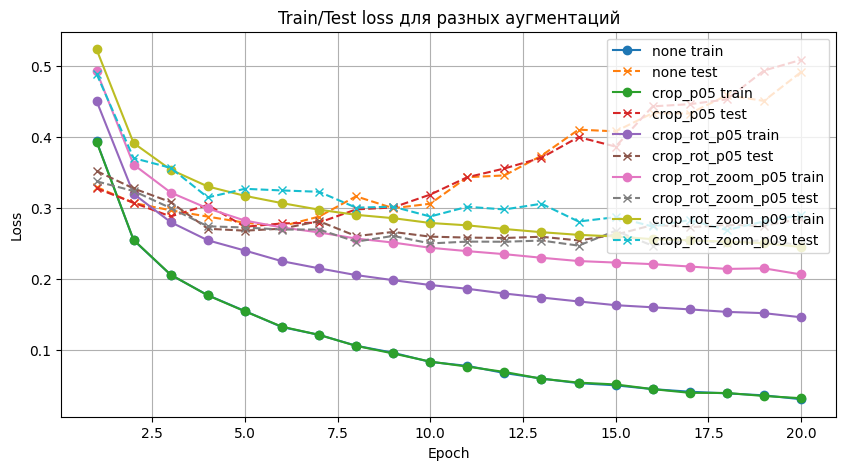

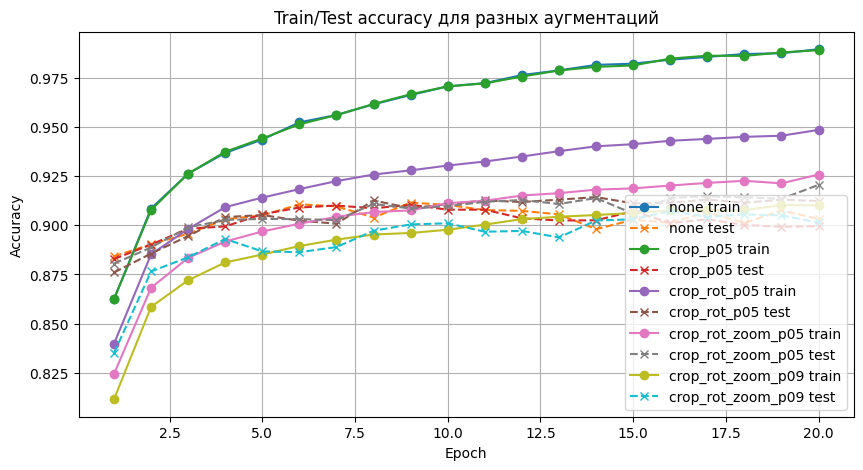

In [ ]:
epochs = range(1, num_epochs + 1)


plt.figure(figsize=(10, 5))
for cfg in config_names:
    plt.plot(epochs, histories[cfg]["train_loss"], linestyle="-", marker="o", label=f"{cfg} train")
    plt.plot(epochs, histories[cfg]["test_loss"], linestyle="--", marker="x", label=f"{cfg} test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Test loss для разных аугментаций")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
for cfg in config_names:
    plt.plot(epochs, histories[cfg]["train_acc"], linestyle="-", marker="o", label=f"{cfg} train")
    plt.plot(epochs, histories[cfg]["test_acc"], linestyle="--", marker="x", label=f"{cfg} test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train/Test accuracy для разных аугментаций")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
!pip install wandb
import wandb

wandb.login(key="")


for cfg in config_names:
    print("\n" + "="*60)
    print(f"CONFIG: {cfg}")
    print("="*60)


    wandb.init(
        project="fashionmnist-augmentations",
        name=f"config_{cfg}",
        config={
            "augmentation": cfg,
            "epochs": num_epochs,
            "batch_size": 128,
        },
        reinit=True
    )


    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)


    train_transform = make_train_transform(cfg)
    train_dataset = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=train_transform
    )
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    model = NeuralNetwork().to(device)


    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} (config={cfg})")

        train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test(test_loader, model, loss_fn)


        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "test_loss": test_loss,
            "test_accuracy": test_acc,
        })





    torch.save(model.state_dict(), f"model_{cfg}.pth")
    wandb.save(f"model_{cfg}.pth")

    wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



CONFIG: none


Epoch 1/5 (config=none)
loss: 2.305167  [  128/60000]
loss: 2.387053  [12928/60000]
loss: 2.437907  [25728/60000]
loss: 2.377608  [38528/60000]
loss: 2.356256  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.367467
Epoch 2/5 (config=none)
loss: 2.393481  [  128/60000]
loss: 2.403906  [12928/60000]
loss: 2.362405  [25728/60000]
loss: 2.392328  [38528/60000]
loss: 2.375777  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.366504
Epoch 3/5 (config=none)
loss: 2.333230  [  128/60000]
loss: 2.357149  [12928/60000]
loss: 2.369239  [25728/60000]
loss: 2.321666  [38528/60000]
loss: 2.431460  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.367515
Epoch 4/5 (config=none)
loss: 2.350581  [  128/60000]
loss: 2.392230  [12928/60000]
loss: 2.366991  [25728/60000]
loss: 2.386404  [38528/60000]
loss: 2.406695  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.367069
Epoch 5/5 (config=none)
loss: 2.356245  [  128/60000]
loss: 2.371957  [12928/60000]
loss: 2.309609  [25728/60000]
lo

epoch,▁▃▅▆█
test_accuracy,█▃▅▄▁
test_loss,█▁█▅▇
train_accuracy,▄▆▁█▇
train_loss,▁▂█▇▄
epoch,5
test_accuracy,0.0784
test_loss,2.36734
train_accuracy,0.07592
train_loss,2.36863



CONFIG: crop_p05


Epoch 1/5 (config=crop_p05)
loss: 2.305167  [  128/60000]
loss: 2.387053  [12928/60000]
loss: 2.437907  [25728/60000]
loss: 2.377608  [38528/60000]
loss: 2.356256  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.367467
Epoch 2/5 (config=crop_p05)
loss: 2.393481  [  128/60000]
loss: 2.403906  [12928/60000]
loss: 2.362405  [25728/60000]
loss: 2.392328  [38528/60000]
loss: 2.375777  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.366504
Epoch 3/5 (config=crop_p05)
loss: 2.333230  [  128/60000]
loss: 2.357149  [12928/60000]
loss: 2.369239  [25728/60000]
loss: 2.321666  [38528/60000]
loss: 2.431460  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.367515
Epoch 4/5 (config=crop_p05)
loss: 2.350581  [  128/60000]
loss: 2.392230  [12928/60000]
loss: 2.366991  [25728/60000]
loss: 2.386404  [38528/60000]
loss: 2.406695  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.367069
Epoch 5/5 (config=crop_p05)
loss: 2.356245  [  128/60000]
loss: 2.371957  [12928/60000]
loss: 2.3096

epoch,▁▃▅▆█
test_accuracy,█▃▅▄▁
test_loss,█▁█▅▇
train_accuracy,▄▆▁█▇
train_loss,▁▂█▇▄
epoch,5
test_accuracy,0.0784
test_loss,2.36734
train_accuracy,0.07592
train_loss,2.36863



CONFIG: crop_rot_p05


Epoch 1/5 (config=crop_rot_p05)
loss: 2.286878  [  128/60000]
loss: 2.359141  [12928/60000]
loss: 2.409840  [25728/60000]
loss: 2.350080  [38528/60000]
loss: 2.350919  [51328/60000]
Test Error: Accuracy: 8.0%, Avg loss: 2.376921
Epoch 2/5 (config=crop_rot_p05)
loss: 2.349783  [  128/60000]
loss: 2.386760  [12928/60000]
loss: 2.331246  [25728/60000]
loss: 2.402642  [38528/60000]
loss: 2.385537  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.376130
Epoch 3/5 (config=crop_rot_p05)
loss: 2.308821  [  128/60000]
loss: 2.360452  [12928/60000]
loss: 2.354114  [25728/60000]
loss: 2.288912  [38528/60000]
loss: 2.388664  [51328/60000]
Test Error: Accuracy: 8.0%, Avg loss: 2.376847
Epoch 4/5 (config=crop_rot_p05)
loss: 2.364850  [  128/60000]
loss: 2.372617  [12928/60000]
loss: 2.348393  [25728/60000]
loss: 2.355761  [38528/60000]
loss: 2.389127  [51328/60000]
Test Error: Accuracy: 8.0%, Avg loss: 2.376233
Epoch 5/5 (config=crop_rot_p05)
loss: 2.362407  [  128/60000]
loss: 2.383796  [12928

epoch,▁▃▅▆█
test_accuracy,▇▁█▅▆
test_loss,█▁▇▂█
train_accuracy,█▁▄▂▂
train_loss,▁▃█▅▅
epoch,5
test_accuracy,0.0797
test_loss,2.37688
train_accuracy,0.09
train_loss,2.35287



CONFIG: crop_rot_zoom_p05


Epoch 1/5 (config=crop_rot_zoom_p05)
loss: 2.260277  [  128/60000]
loss: 2.362482  [12928/60000]
loss: 2.406466  [25728/60000]
loss: 2.354566  [38528/60000]
loss: 2.349832  [51328/60000]
Test Error: Accuracy: 7.8%, Avg loss: 2.388605
Epoch 2/5 (config=crop_rot_zoom_p05)
loss: 2.392497  [  128/60000]
loss: 2.398674  [12928/60000]
loss: 2.309816  [25728/60000]
loss: 2.379505  [38528/60000]
loss: 2.355584  [51328/60000]
Test Error: Accuracy: 7.8%, Avg loss: 2.386768
Epoch 3/5 (config=crop_rot_zoom_p05)
loss: 2.307946  [  128/60000]
loss: 2.308836  [12928/60000]
loss: 2.380505  [25728/60000]
loss: 2.358476  [38528/60000]
loss: 2.382272  [51328/60000]
Test Error: Accuracy: 7.8%, Avg loss: 2.388848
Epoch 4/5 (config=crop_rot_zoom_p05)
loss: 2.342140  [  128/60000]
loss: 2.355936  [12928/60000]
loss: 2.377613  [25728/60000]
loss: 2.339167  [38528/60000]
loss: 2.391605  [51328/60000]
Test Error: Accuracy: 7.8%, Avg loss: 2.388224
Epoch 5/5 (config=crop_rot_zoom_p05)
loss: 2.372586  [  128/6000

epoch,▁▃▅▆█
test_accuracy,▁▁▆▁█
test_loss,▇▁█▆▆
train_accuracy,▁█▆▆▄
train_loss,▃▃▁▃█
epoch,5
test_accuracy,0.0784
test_loss,2.38811
train_accuracy,0.08455
train_loss,2.36077



CONFIG: crop_rot_zoom_p09


Epoch 1/5 (config=crop_rot_zoom_p09)
loss: 2.276395  [  128/60000]
loss: 2.338247  [12928/60000]
loss: 2.403471  [25728/60000]
loss: 2.360269  [38528/60000]
loss: 2.352695  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.412741
Epoch 2/5 (config=crop_rot_zoom_p09)
loss: 2.369668  [  128/60000]
loss: 2.371961  [12928/60000]
loss: 2.321814  [25728/60000]
loss: 2.356259  [38528/60000]
loss: 2.315615  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.410501
Epoch 3/5 (config=crop_rot_zoom_p09)
loss: 2.336788  [  128/60000]
loss: 2.343501  [12928/60000]
loss: 2.342348  [25728/60000]
loss: 2.336160  [38528/60000]
loss: 2.389622  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.412887
Epoch 4/5 (config=crop_rot_zoom_p09)
loss: 2.368463  [  128/60000]
loss: 2.316823  [12928/60000]
loss: 2.374123  [25728/60000]
loss: 2.360319  [38528/60000]
loss: 2.363398  [51328/60000]
Test Error: Accuracy: 7.9%, Avg loss: 2.411382
Epoch 5/5 (config=crop_rot_zoom_p09)
loss: 2.344596  [  128/6000

epoch,▁▃▅▆█
test_accuracy,▃▁▃▁█
test_loss,█▁█▄▇
train_accuracy,▄▁██▃
train_loss,▆█▆▄▁
epoch,5
test_accuracy,0.0789
test_loss,2.41249
train_accuracy,0.0853
train_loss,2.3529


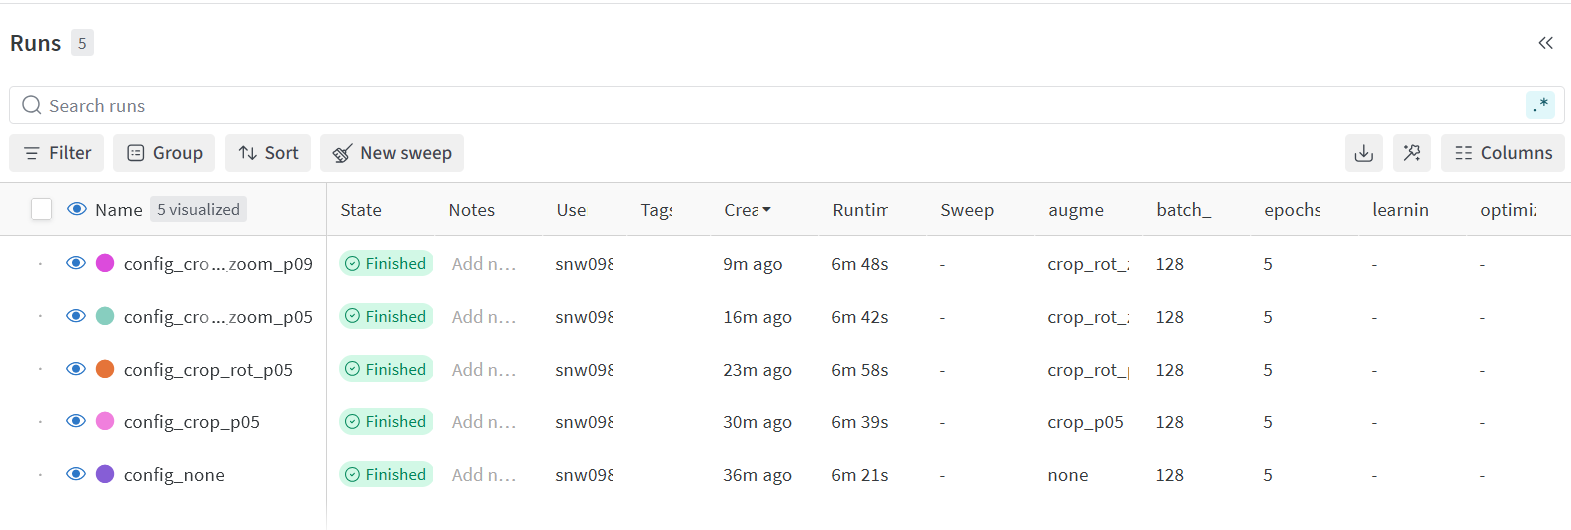


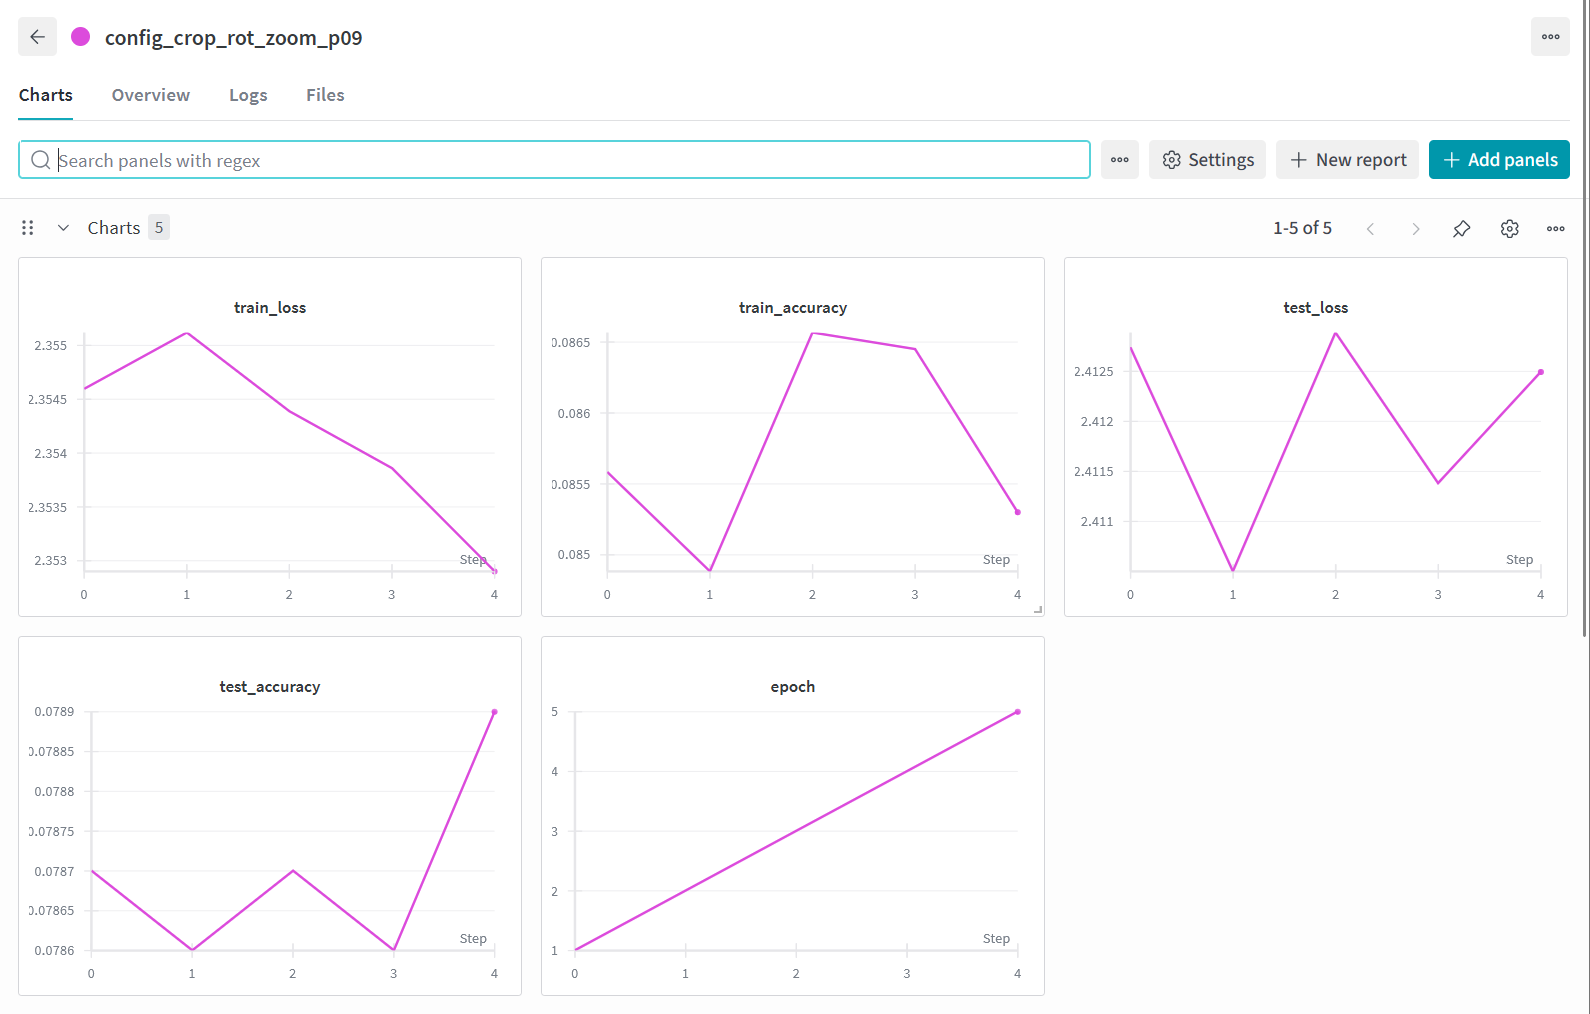

